In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats import weightstats as stests

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

data = pd.read_csv('Google-Playstore-Full.csv')
data.head()

C:\Users\Nikhil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,DoorDash - Food Delivery,FOOD_AND_DRINK,4.548561573,305034,"5,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
1,TripAdvisor Hotels Flights Restaurants Attract...,TRAVEL_AND_LOCAL,4.400671482,1.20792e+06,"100,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
2,Peapod,SHOPPING,3.656329393,1967,"100,000+",1.4M,0,Everyone,"September 20, 2018",5.0 and up,2.2.0,NaN,NaN,NaN,NaN
3,foodpanda - Local Food Delivery,FOOD_AND_DRINK,4.107232571,389154,"10,000,000+",16M,0,Everyone,"March 22, 2019",4.2 and up,4.18.2,NaN,NaN,NaN,NaN
4,My CookBook Pro (Ad Free),FOOD_AND_DRINK,4.647752285,2291,"10,000+",Varies with device,$5.99,Everyone,"April 1, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN


In [28]:
data = data.drop(columns = ['App Name', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Last Updated', 'Minimum Version', 'Latest Version'])
data = data.rename(columns={'Content Rating':'CR'})


In [29]:
data = data[data.Size.str.contains('\d')]
data.Size[data.Size.str.contains('k')] = "0."+data.Size[data.Size.str.contains('k')].str.replace('.','')
data.Size = data.Size.str.replace('k','')
data.Size = data.Size.str.replace('M','')
data.Size = data.Size.str.replace(',','')
data.Size = data.Size.str.replace('+','')
data.Size = data.Size.astype(float)

data = data[data.Installs.str.contains('\+')]
data.Installs = data.Installs.str.replace('+','')
data.Installs = data.Installs.str.replace(',','')
data.Installs.astype(int)

data.Price = data.Price.str.contains('1|2|3|4|5|7|8|9').replace(False, 0)

data = data[data.applymap(np.isreal).Reviews]
data.Reviews = data.Reviews.astype(float)

data = data[data.Rating.str.contains('\d') == True]
data.Rating = data.Rating.astype(float)
print(data.head())

            Category    Rating   Reviews  Installs  Size  Price        CR
2           SHOPPING  3.656329    1967.0    100000   1.4    0.0  Everyone
3     FOOD_AND_DRINK  4.107233  389154.0  10000000  16.0    0.0  Everyone
5     FOOD_AND_DRINK  3.825322    2559.0    100000  23.0    0.0  Everyone
8   TRAVEL_AND_LOCAL  3.811765      85.0     10000   4.1    0.0  Everyone
12         LIFESTYLE  3.213528     754.0    100000  39.0    0.0  Everyone


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186891 entries, 2 to 196607
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Category  186891 non-null  object 
 1   Rating    186891 non-null  float64
 2   Reviews   186891 non-null  float64
 3   Installs  186891 non-null  object 
 4   Size      186891 non-null  float64
 5   Price     186891 non-null  float64
 6   CR        186891 non-null  object 
dtypes: float64(4), object(3)
memory usage: 11.4+ MB


In [4]:
data.Category.unique()


array(['SHOPPING', 'FOOD_AND_DRINK', 'TRAVEL_AND_LOCAL', 'LIFESTYLE',
       'GAME_ACTION', 'GAME_CASUAL', 'GAME_ROLE_PLAYING', 'GAME_PUZZLE',
       'GAME_ADVENTURE', 'GAME_ARCADE', 'GAME_STRATEGY', 'GAME_SPORTS',
       'GAME_SIMULATION', 'GAME_MUSIC', 'MUSIC_AND_AUDIO', 'FINANCE',
       'EVENTS', 'ENTERTAINMENT', 'EDUCATION', 'GAME_EDUCATIONAL',
       'BOOKS_AND_REFERENCE', 'PHOTOGRAPHY', 'VIDEO_PLAYERS',
       'NEWS_AND_MAGAZINES', 'GAME_WORD', 'ART_AND_DESIGN', 'GAME_TRIVIA',
       'GAME_BOARD', 'BUSINESS', 'PRODUCTIVITY', 'COMMUNICATION',
       'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME', 'BEAUTY', 'SOCIAL',
       'MAPS_AND_NAVIGATION', 'GAME_CASINO', 'GAME_CARD', 'SPORTS',
       'AUTO_AND_VEHICLES', 'GAME_RACING', 'TOOLS', 'PERSONALIZATION',
       'LIBRARIES_AND_DEMO', 'COMICS', 'DATING', 'WEATHER', 'PARENTING',
       'MEDICAL', 'TRAVEL'], dtype=object)

In [5]:
data.Category = data.Category.fillna('Unknown')
games = data[data.Category.str.contains('GAME', regex=False)]
other = data[~data.Category.str.contains('GAME', regex=False)]

In [6]:
z_Rating = np.abs(stats.zscore(games.Rating))
games = games[z_Rating < 3]
z_Reviews = np.abs(stats.zscore(games.Reviews))
games = games[z_Reviews < 3]

z_Rating2 = np.abs(stats.zscore(other.Rating))
other = other[z_Rating2 < 3]
z_Reviews2 = np.abs(stats.zscore(other.Reviews))
other = other[z_Reviews2 < 3]

In [7]:
games_mean = np.mean(games.Rating)
games_std = np.std(games.Rating)

other_mean = np.mean(other.Rating)
other_std = np.std(games.Rating)

print('Games mean and std: ', games_mean, games_std)
print('Other categories mean and std: ', other_mean, other_std)

ztest, pval = stests.ztest(games.Rating, other.Rating, usevar='pooled', value=0, alternative='smaller')
print('p-value: ', pval)

Games mean and std:  4.306886710110457 0.38866039199547325
Other categories mean and std:  4.314121683386176 0.38866039199547325
p-value:  0.03214692236237652


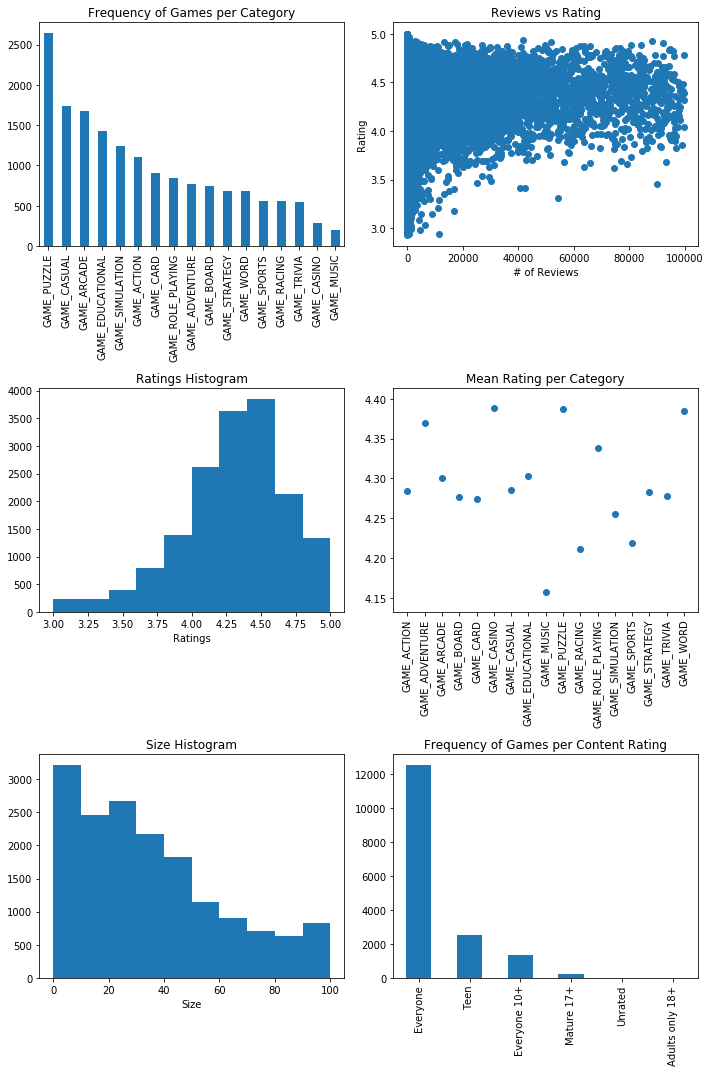

In [8]:
f, ax = plt.subplots(3,2,figsize=(10,15))

games.Category.value_counts().plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title('Frequency of Games per Category')

ax[0,1].scatter(games.Reviews[games.Reviews < 100000], games.Rating[games.Reviews < 100000])
ax[0,1].set_title('Reviews vs Rating')
ax[0,1].set_xlabel('# of Reviews')
ax[0,1].set_ylabel('Rating')

ax[1,0].hist(games.Rating, range=(3,5))
ax[1,0].set_title('Ratings Histogram')
ax[1,0].set_xlabel('Ratings')

d = games.groupby('Category')['Rating'].mean().reset_index()
ax[1,1].scatter(d.Category, d.Rating)
ax[1,1].set_xticklabels(d.Category.unique(),rotation=90)
ax[1,1].set_title('Mean Rating per Category')

ax[2,0].hist(games.Size, range=(0,100),bins=10, label='Size')
ax[2,0].set_title('Size Histogram')
ax[2,0].set_xlabel('Size')

games.CR.value_counts().plot(kind='bar', ax=ax[2,1])
ax[2,1].set_title('Frequency of Games per Content Rating')
f.tight_layout()


In [9]:
games_dum = pd.get_dummies(games, columns=['Category','CR','Price'])


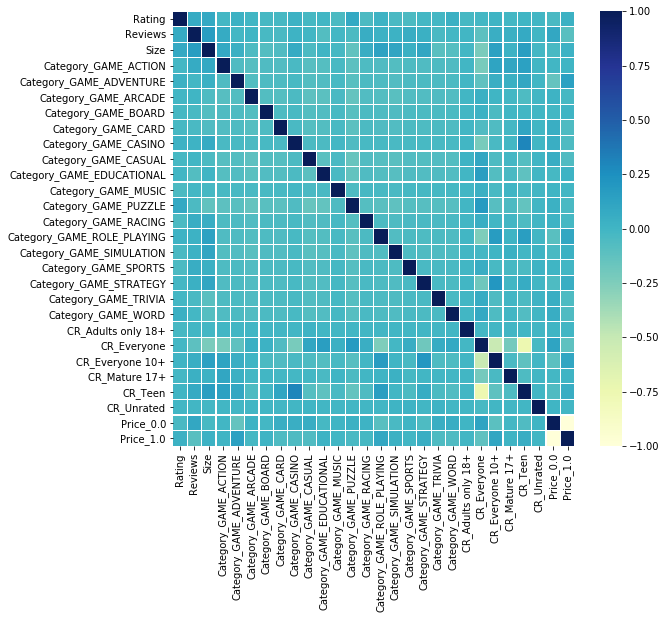

In [10]:
corrmat = games_dum.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)


In [11]:
other = other[other.Category.map(other.Category.value_counts() > 3500)]


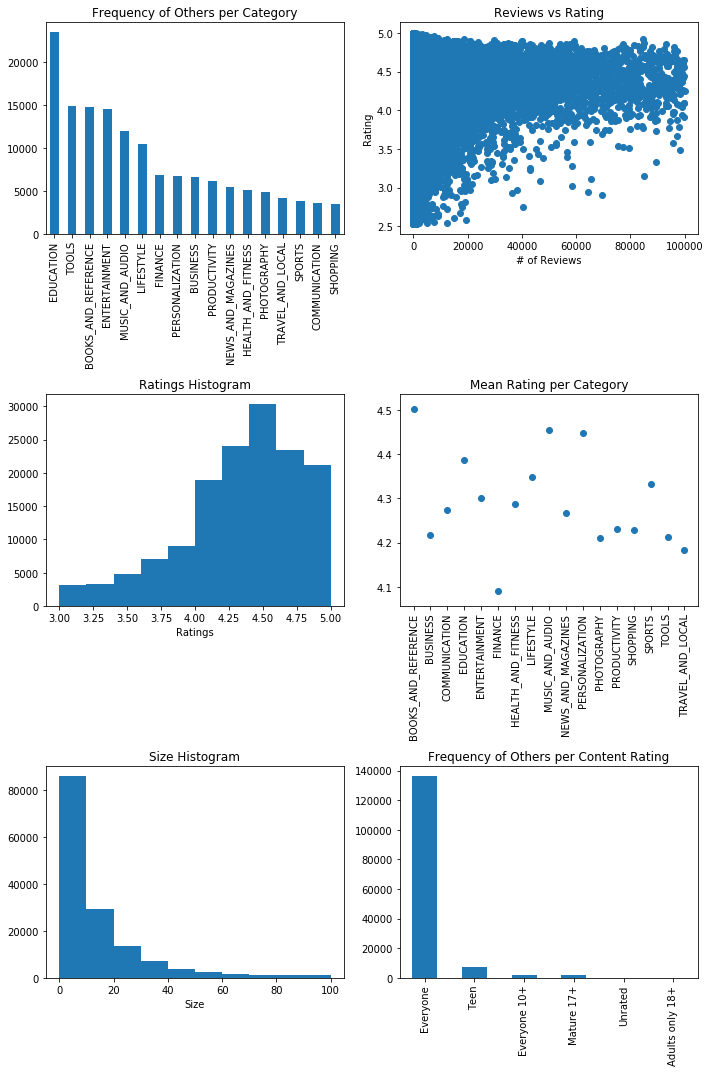

In [12]:
f, ax = plt.subplots(3,2,figsize=(10,15))

other.Category.value_counts().plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title('Frequency of Others per Category')

ax[0,1].scatter(other.Reviews[other.Reviews < 100000], other.Rating[other.Reviews < 100000])
ax[0,1].set_title('Reviews vs Rating')
ax[0,1].set_xlabel('# of Reviews')
ax[0,1].set_ylabel('Rating')

ax[1,0].hist(other.Rating, range=(3,5))
ax[1,0].set_title('Ratings Histogram')
ax[1,0].set_xlabel('Ratings')

d = other.groupby('Category')['Rating'].mean().reset_index()
ax[1,1].scatter(d.Category, d.Rating)
ax[1,1].set_xticklabels(d.Category.unique(),rotation=90)
ax[1,1].set_title('Mean Rating per Category')

ax[2,0].hist(other.Size, range=(0,100),bins=10, label='Size')
ax[2,0].set_title('Size Histogram')
ax[2,0].set_xlabel('Size')

other.CR.value_counts().plot(kind='bar', ax=ax[2,1])
ax[2,1].set_title('Frequency of Others per Content Rating')

f.tight_layout()

In [13]:
other_dum = pd.get_dummies(other, columns=['Category','CR','Price'])


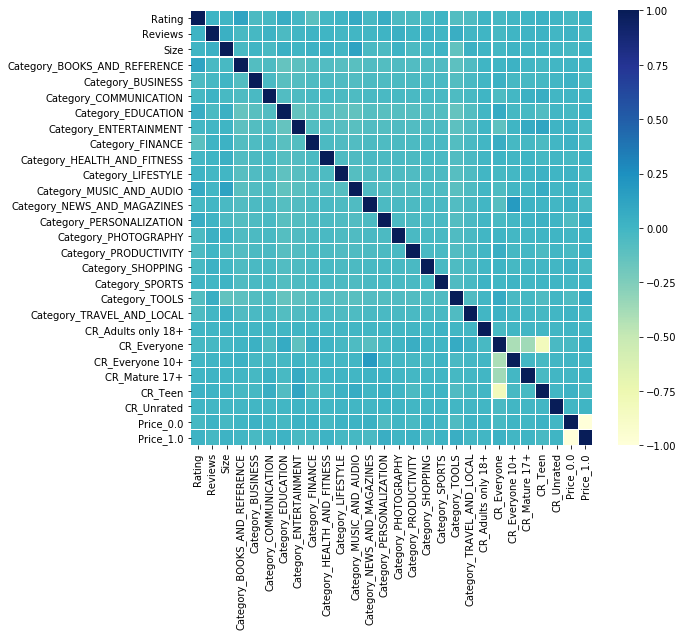

In [14]:
corrmat = other_dum.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [15]:
y = games_dum.Rating
X = games_dum.drop(columns=['Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (12471, 28) (12471,)
Test (4157, 28) (4157,)


In [16]:
reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test,pred)

print('MAE: ', mae)
print('RMSE: ', np.sqrt(mse))
print('R2: ', r2)

MAE:  0.2873224305634914
RMSE:  0.37672685290721464
R2:  0.0412588901809221


In [21]:
d = range(4)
for degree in d:
    poly = PolynomialFeatures(degree=degree)
    Xpoly = poly.fit_transform(X)
    Xpoly_test = poly.fit_transform(X_test)

    polyreg = LinearRegression()
    polyreg.fit(Xpoly, y)
    predpoly = polyreg.predict(Xpoly_test)

    mae2 = mean_absolute_error(y_test, predpoly)
    mse2 = mean_squared_error(y_test, predpoly)
    r2poly = r2_score(y_test,pred)
    
    print('Degree: ', degree)
    print('MAE: ', mae2)
    print('RMSE: ', np.sqrt(mse2))
    print('R2: ', r2poly)

ValueError: could not broadcast input array from shape (16628,28) into shape (16628,0)